In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [2]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import time

In [3]:
import torch

In [ ]:
!wget https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset/resolve/main/train.csv
!wget https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset/resolve/main/datasets.csv
!wget https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset/resolve/main/valid.csv

In [ ]:
ds = pd.read_csv("datasets.csv")
ds.head(3)

,Unnamed: 0,text,sentiment
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1
1,17755,Отель выбрали потому что рядом со стадионом. О...,0
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1


In [5]:
df = pd.read_csv("train.csv")
df.head(3)

,Unnamed: 0,text,sentiment
0,21098,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,21099,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,21100,Непорядочное отношение к своим работникам Рабо...,2


In [ ]:
df.shape

(189891, 3)

In [ ]:
df.dtypes

,0
Unnamed: 0,int64
text,object
sentiment,int64


In [ ]:
df.isnull().sum() # Проверим наличие пропущенных значений

,0
Unnamed: 0,0
text,0
sentiment,0


Распределение меток сентимента:

In [ ]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
1,90766
2,49798
0,49327


Статистика по длине текстов

In [ ]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

,text_length
count,189891.000000
mean,800.320020
std,1951.543585
min,3.000000
25%,278.000000
50%,503.000000
75%,909.000000
max,381498.000000


Длина текста по меткам сентимента

Text(0, 0.5, 'Длина текста')

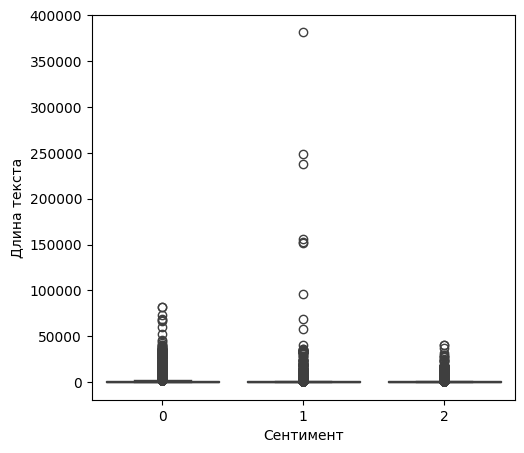

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.xlabel('Сентимент')
plt.ylabel('Длина текста')

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
stop_words = set(stopwords.words('russian'))

Предобработка текста

In [8]:
def preprocess_text(text):
  text = text.lower()
  # Удаление специальных символов и цифр
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  tokens = word_tokenize(text)
  tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
  return ' '.join(tokens)

In [9]:
df['processed_text'] = df['text'].apply(preprocess_text)

Самые часто встречаемые слова

In [ ]:
all_words = ' '.join(df['processed_text']).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)

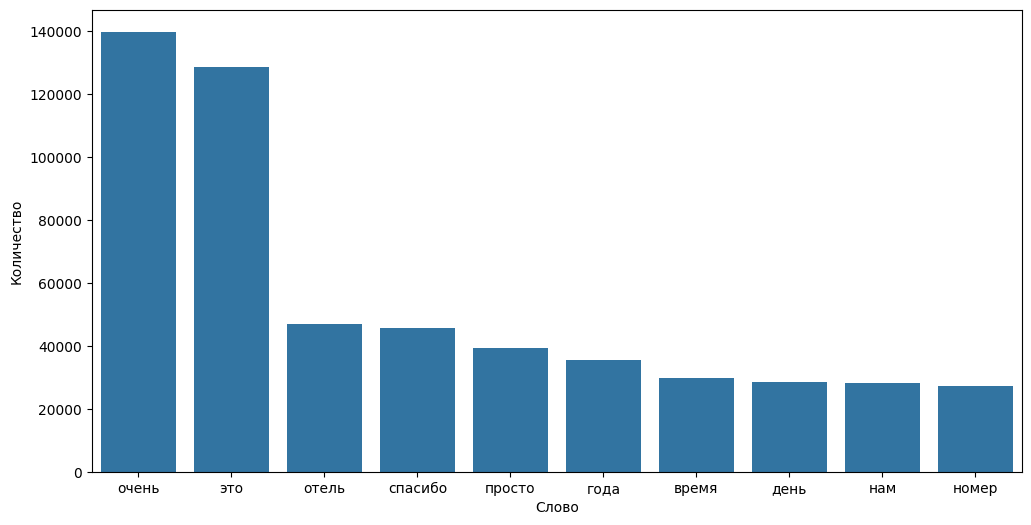

In [ ]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xlabel('Слово')
plt.ylabel('Количество')
plt.show()

Я решил попробовать LDA, NMF. Здесь немалый объем текстов, хотя сами тексты небольшие. Предполагаю, что NMF будет работать быстрее, чем LDA.

Векторизация текстов с помощью TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
feature_names = vectorizer.get_feature_names_out()

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
count_matrix = count_vectorizer.fit_transform(df['processed_text'])
count_feature_names = count_vectorizer.get_feature_names_out()

# Определение оптимального количества тем с помощью метрик

# 1. Для LDA: используем перплексию и метрику когерентности
def compute_coherence_values(model, term_matrix, feature_names, texts, top_n=10):
    """
    Вычисляет метрику когерентности C_v для заданной модели
    """
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-top_n - 1:-1]
        topic_terms = [feature_names[i] for i in top_words_idx]
        topic_words.append(topic_terms)

    # Вычисляем когерентность как среднее попарное сходство между топ-словами
    coherence = 0
    term_counts = term_matrix.sum(axis=0)
    term_counts = np.asarray(term_counts)[0]

    # Вычисляем среднюю когерентность по всем темам
    total_coherence = 0
    for topic in topic_words:
        topic_coherence = 0
        pairs = 0
        for i in range(len(topic)):
            for j in range(i+1, len(topic)):
                # Используем простую метрику: PMI
                word_i = topic[i]
                word_j = topic[j]

                idx_i = list(feature_names).index(word_i) if word_i in feature_names else -1
                idx_j = list(feature_names).index(word_j) if word_j in feature_names else -1

                if idx_i != -1 and idx_j != -1:
                    # PMI как оценка когерентности
                    count_i = term_counts[idx_i]
                    count_j = term_counts[idx_j]

                    # Находим документы с обоими словами
                    docs_with_i = set(term_matrix[:, idx_i].nonzero()[0])
                    docs_with_j = set(term_matrix[:, idx_j].nonzero()[0])
                    docs_with_both = docs_with_i.intersection(docs_with_j)

                    if len(docs_with_both) > 0:
                        # PMI
                        pmi = np.log((len(docs_with_both) * len(texts)) / (len(docs_with_i) * len(docs_with_j)))
                        if not np.isnan(pmi) and not np.isinf(pmi):
                            topic_coherence += pmi
                            pairs += 1

        if pairs > 0:
            topic_coherence /= pairs
            total_coherence += topic_coherence

    if len(topic_words) > 0:
        total_coherence /= len(topic_words)

    return total_coherence

# Диапазон количества тем для тестирования
step = 10
topics_range = range(1, 70, step)

# Метрики для LDA
lda_perplexity = []
lda_coherence = []

# Метрики для NMF: реконструкционная ошибка и когерентность
nmf_errors = []
nmf_coherence = []

for n_topics in topics_range:
    print(f"Проверка модели с {n_topics} темами...")

    # LDA модель
    lda = LatentDirichletAllocation(n_components=n_topics,
                                    random_state=42,
                                    max_iter=10)
    lda.fit(tfidf_matrix)

    # Вычисляем перплексию
    perplexity = lda.perplexity(tfidf_matrix)
    lda_perplexity.append(perplexity)

    # Вычисляем когерентность для LDA
    lda_c_v = compute_coherence_values(lda, count_matrix, count_feature_names, df['processed_text'])
    lda_coherence.append(lda_c_v)

    nmf = NMF(n_components=n_topics,
          random_state=42,
          max_iter=1000)
    W = nmf.fit_transform(tfidf_matrix)
    H = nmf.components_

    # Правильный расчет реконструкционной ошибки
    reconstructed = W @ H
    error = np.linalg.norm(tfidf_matrix.toarray() - reconstructed, 'fro') / np.linalg.norm(tfidf_matrix.toarray(), 'fro')
    nmf_errors.append(error)

    # Вычисляем когерентность для NMF
    nmf_c_v = compute_coherence_values(nmf, count_matrix, count_feature_names, df['processed_text'])
    nmf_coherence.append(nmf_c_v)


Вычисление оптимального количества тем...
Это может занять некоторое время...
Проверка модели с 1 темами...
Проверка модели с 11 темами...
Проверка модели с 21 темами...
Проверка модели с 31 темами...
Проверка модели с 41 темами...
Проверка модели с 51 темами...
Проверка модели с 61 темами...


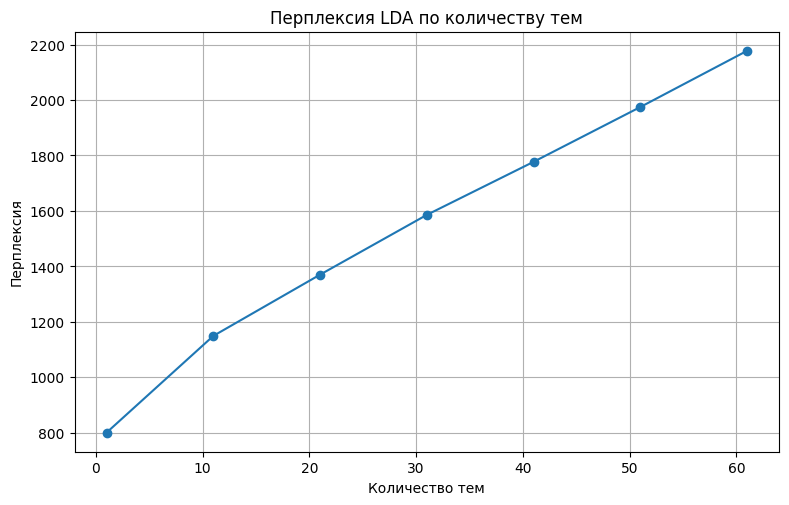

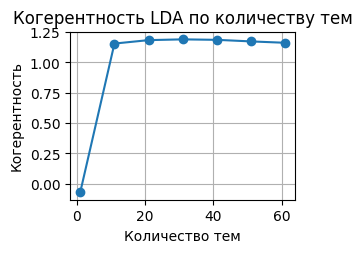

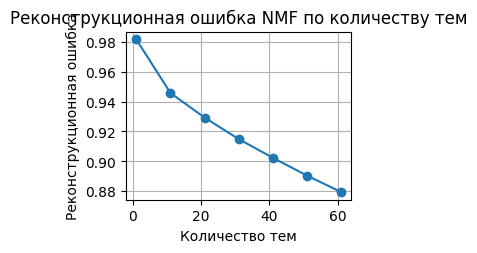

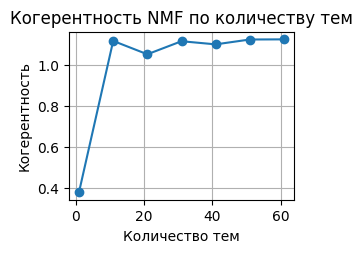

In [ ]:
# Визуализация результатов для выбора оптимального количества тем
plt.figure(figsize=(20, 12))

# График перплексии LDA
plt.subplot(2, 2, 1)
plt.plot(topics_range, lda_perplexity, marker='o')
plt.xlabel('Количество тем')
plt.ylabel('Перплексия')
plt.title('Перплексия LDA по количеству тем')
plt.grid(True)
plt.show()

# График когерентности LDA
plt.subplot(2, 2, 2)
plt.plot(topics_range, lda_coherence, marker='o')
plt.xlabel('Количество тем')
plt.ylabel('Когерентность')
plt.title('Когерентность LDA по количеству тем')
plt.grid(True)
plt.show()

# График реконструкционной ошибки NMF
plt.subplot(2, 2, 3)
plt.plot(topics_range, nmf_errors, marker='o')
plt.xlabel('Количество тем')
plt.ylabel('Реконструкционная ошибка')
plt.title('Реконструкционная ошибка NMF по количеству тем')
plt.grid(True)
plt.show()

# График когерентности NMF
plt.subplot(2, 2, 4)
plt.plot(topics_range, nmf_coherence, marker='o')
plt.xlabel('Количество тем')
plt.ylabel('Когерентность')
plt.title('Когерентность NMF по количеству тем')
plt.grid(True)
plt.show()


# Определение оптимального количества тем на основе метрик
# Для LDA: баланс между перплексией и когерентностью
# - Нормализуем метрики
norm_perplexity = (lda_perplexity - np.min(lda_perplexity)) / (np.max(lda_perplexity) - np.min(lda_perplexity))
norm_coherence = (lda_coherence - np.min(lda_coherence)) / (np.max(lda_coherence) - np.min(lda_coherence))

lda_scores = 1 - norm_perplexity + norm_coherence

Судя по графикам когерентности для обоих моделей оптимальное количество тем примерно 11

Определение оптимального количества тем на основе метрик. <br>
Для LDA нужен баланс между перплексией и когерентностью

In [ ]:
norm_perplexity = (lda_perplexity - np.min(lda_perplexity)) / (np.max(lda_perplexity) - np.min(lda_perplexity)) # нормализация
norm_coherence = (lda_coherence - np.min(lda_coherence)) / (np.max(lda_coherence) - np.min(lda_coherence))

# Чем ниже перплексия и выше когерентность, тем лучше модель
lda_scores = 1 - norm_perplexity + norm_coherence
optimal_lda_topics = topics_range[np.argmax(lda_scores)]

print(f"\nОптимальное количество тем для LDA: {optimal_lda_topics}")


Оптимальное количество тем для LDA: 11


Для NMF нужен баланс между реконструкционной ошибкой и когерентностью

In [ ]:
norm_errors = (nmf_errors - np.min(nmf_errors)) / (np.max(nmf_errors) - np.min(nmf_errors))
norm_nmf_coherence = (nmf_coherence - np.min(nmf_coherence)) / (np.max(nmf_coherence) - np.min(nmf_coherence))

# Чем ниже ошибка и выше когерентность, тем лучше модель
nmf_scores = 1 - norm_errors + norm_nmf_coherence
optimal_nmf_topics = topics_range[np.argmax(nmf_scores)]
print(f"Оптимальное количество тем для NMF: {optimal_nmf_topics}")

Оптимальное количество тем для NMF: 61


Теперь применяем модели с оптимальным количеством тем

In [ ]:
n_topics_lda = optimal_lda_topics
n_topics_nmf = optimal_nmf_topics

lda_model = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42, max_iter=10)
lda_matrix = lda_model.fit_transform(tfidf_matrix)

nmf_model = NMF(n_components=n_topics_nmf, random_state=42, max_iter=1000)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

Топ слова для каждой темы

In [ ]:
def print_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append((topic_idx, top_words))
        print(f"Тема #{topic_idx + 1}: {', '.join(top_words)}")
    return topics

In [ ]:
lda_topics = print_top_words(lda_model, feature_names)

Тема #1: отель, очень, цены, номера, персонал, цена, расположение, отеле, качество, отеля
Тема #2: отель, очень, номер, номера, отеля, отеле, номере, завтрак, рядом, персонал
Тема #3: очень, спасибо, обслуживание, кухня, ресторан, вкусно, понравилось, место, ресторане, всем
Тема #4: врач, узи, это, анализы, зуб, прием, врача, деньги, пришла, клинику
Тема #5: машина, автомобиль, это, авто, очень, машину, года, машины, салон, лет
Тема #6: это, просто, россии, вообще, всё, ещё, почему, люди, которые, людей
Тема #7: это, врач, врачи, ребенка, отношение, врача, просто, больнице, больницу, отделение
Тема #8: очень, спасибо, клинике, клиника, клинику, клиники, довольна, зубы, лечение, врачи
Тема #9: спасибо, благодарность, хочу, огромное, выразить, отделения, отношение, очень, большое, поблагодарить
Тема #10: года, тенге, году, казахстана, также, казахстан, области, млрд, алматы, банка
Тема #11: очень, это, меню, ресторан, нам, принесли, интерьер, просто, заказ, салат


In [ ]:
nmf_topics = print_top_words(nmf_model, feature_names)

Тема #1: меню, вкусно, ресторане, ресторана, интерьер, блюда, салат, блюд, официанты, зал
Тема #2: это, плюс, единственный, заведение, значит, минус, важно, скорее, самый, правда
Тема #3: спасибо, огромное, отдельное, персоналу, всему, врачам, благодаря, профессионализм, помощь, ваш
Тема #4: очень, понравился, удобно, приятно, довольны, нравится, понравилась, вкусно, красиво, часто
Тема #5: врач, бога, замечательный, внимательный, сказала, сказал, медсестра, работает, лучший, приеме
Тема #6: тенге, также, году, казахстана, млрд, казахстан, области, развития, банка, енпф
Тема #7: довольна, осталась, рожала, буду, роды, роддоме, делала, роддом, родов, общем
Тема #8: благодарность, выразить, огромную, отделения, врачу, сотрудникам, профессионализм, всему, огромная, здоровья
Тема #9: отель, расположен, находится, завтраки, понравился, уютный, чистый, новый, недалеко, небольшой
Тема #10: просто, ужас, замечательно, невозможно, слов, такое, какие, туда, такого, повезло
Тема #11: всё, равно, 

До этого я запускал LDA до 15 тем и оно стремилось к 11.

### Проанализировав топ слова из 11 тем LDA, можно сделать вывод что тексты - это отзывы и их можно разделить примерно на 5 тем: **отели, рестораны, больницы, банки и автомобили**. ###

# Часть  2#

In [10]:
test_df = pd.read_csv("valid.csv")

Разделяем train на обучающую и валидационную выборки

In [11]:
test_df['processed_text'] = df['text'].apply(preprocess_text)

X_temp = df['processed_text']
y_temp = df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,  # 20% для валидации
    random_state=42,
    stratify=y_temp  # распределение классов
)

X_test = test_df['processed_text']
y_test = test_df['sentiment']

In [12]:
print(f"Размер финальной обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер финальной обучающей выборки: 151912
Размер валидационной выборки: 37979
Размер тестовой выборки: 21098


In [13]:
# Проверьте уникальные значения меток
print("Уникальные значения в y_train:", np.unique(y_train))
print("Уникальные значения в y_val:", np.unique(y_val))
print("Уникальные значения в y_test:", np.unique(y_test))


Уникальные значения в y_train: [0 1 2]
Уникальные значения в y_val: [0 1 2]
Уникальные значения в y_test: [0 1 2]


Я решил не брать модели классического мл и сразу взял ruBert

Параллельно все-таки решил еще обучить CatBoost, но он выдал плохие метрики. Подозреваю, что это потому что я использовал TF-IDF, а не WordtoVec

In [ ]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Параметры
batch_size = 16
epochs = 5
learning_rate = 2e-5
max_length = 128
weight_decay = 0.01

**Параметры** :<br>
Размер батча: 16 - норм для скорости обучения и памяти GPU <br>
Количество эпох: 5 - достаточно для fine-tuning предобученной модели <br>
Learning rate: 2e-5 - стандартное значение для fine-tuning BERT-моделей <br>
Max length: 128 - оптимальная длина для коротких текстовых отзывов <br>
Weight decay: 0.01 - чтобы не было переобучения

In [ ]:
# Подготовка данных для модели
def prepare_data(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels.tolist())

    return TensorDataset(input_ids, attention_mask, labels)

# Создание DataLoader
train_dataset = prepare_data(X_train, y_train, tokenizer, max_length)
val_dataset = prepare_data(X_val, y_val, tokenizer, max_length)
test_dataset = prepare_data(X_test, y_test, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Настройка scheduler для изменения learning rate
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Функция для обучения на одной эпохе
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

# Функция для оценки на валидационной/тестовой выборке
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }

            outputs = model(**inputs)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    return true_labels, predictions

# Обучение модели
best_val_f1 = 0
best_model_state = None

for epoch in range(epochs):
    print(f"Эпоха {epoch + 1}/{epochs}")


    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    print(f"Среднее значение потерь: {train_loss:.4f}")

    # Оценка на валидационной выборке
    true_labels, predictions = evaluate(model, val_dataloader, device)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    print(f"Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Сохранение лучшей модели по F1
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_state = model.state_dict().copy()
        print("Сохранена новая лучшая модель!")

# Загрузка лучшей модели
model.load_state_dict(best_model_state)

Эпоха 1/5
Среднее значение потерь: 0.5332
Validation - Accuracy: 0.7861, Precision: 0.7895, Recall: 0.7861, F1: 0.7868
Сохранена новая лучшая модель!
Эпоха 2/5
Среднее значение потерь: 0.4040
Validation - Accuracy: 0.7976, Precision: 0.8002, Recall: 0.7976, F1: 0.7984
Сохранена новая лучшая модель!
Эпоха 3/5
Среднее значение потерь: 0.3089
Validation - Accuracy: 0.7929, Precision: 0.7963, Recall: 0.7929, F1: 0.7942
Эпоха 4/5


KeyboardInterrupt: 

Пришлось остановить модель после трех эпох, т.к уже не было времени, но не смотря на это, модель уже после первой эпохи показала хорошие метрики